In [1]:
from importlib import reload
import utils; reload(utils)
from utils import *
data_path =  '/Volumes/Backups/data/LUNA16/patches/'

Using cuDNN version 5105 on context None
Preallocating 2867/4095 Mb (0.700000) on cuda0
Mapped name None to device cuda0: GeForce GTX 650 (0000:01:00.0)
Using Theano backend.


In [2]:
%matplotlib inline
import os, random
from shutil import copytree
data_path =  '/Volumes/Backups/data/LUNA16/patches/'

In [3]:
#for i in range(10):
#    patches1 = random.choice(os.listdir("/Volumes/Backups/data/LUNA16/patches/patches1/"))
#    patches0 = random.choice(os.listdir("/Volumes/Backups/data/LUNA16/patches/patches0/"))
#    copytree(data_path + 'patches1/' + patches1, '/Volumes/Backups/data/LUNA16/patches/sample/patches1/' + patches1)
#    copytree(data_path + 'patches0/' + patches0, '/Volumes/Backups/data/LUNA16/patches/sample/patches0/' + patches0)
#    

FileExistsError: [Errno 17] File exists: '/Volumes/Backups/data/LUNA16/patches/sample/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051_911_224x224.bc'

In [4]:
import numpy as np
np.set_printoptions(precision=4,linewidth=100)
import pandas as pd
from vgg16bn import Vgg16BN

In [5]:
model = vgg_ft_bn(2)

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [6]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(2)


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [8]:
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
from skimage import color

In [10]:
np.sctypes

{'complex': [numpy.complex64, numpy.complex128, numpy.complex256],
 'float': [numpy.float16, numpy.float32, numpy.float64, numpy.float128],
 'int': [numpy.int8, numpy.int16, numpy.int32, numpy.int64],
 'others': [bool, object, str, str, numpy.void],
 'uint': [numpy.uint8, numpy.uint16, numpy.uint32, numpy.uint64]}

In [11]:
np_img = np.zeros((1,224,224))

In [12]:
np_img[0] =  np.asarray(img,dtype=np.float32)

NameError: name 'img' is not defined

In [13]:
np_img


array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])

In [70]:
import glob2
image_list = []
image_labels = []
img_array = np.zeros((1,3,224,224),dtype=np.float32)
print(type(img_array[0][0][0][0]))
i=0
#for filename in glob2.glob(data_path+'sample/*/*'):
for filename in (os.listdir(data_path + "sample/")):
    print(filename)
    for image in  glob2.glob(data_path + "sample/" + filename+'/*'):
        if (filename == 'patches0'):
            image_labels.append(np.float32(0.0))
            print(type(image_labels[0]))
        else:
            image_labels.append(np.float32(1.0))
        print ("imagename: " + image)
        img = color.gray2rgb(load_array(image)).astype(np.float32)
        print("img type: " + str(type(img[0][0][0])))
        np_img = np.transpose(np.asarray(img,dtype=np.float32),(2,0,1))
        print(np_img.shape)
        print("np_img type : " + str(type(np_img[0][0][0])))
        tmp_img = np.zeros((1,3,224,224),dtype=np.float32)
        print(tmp_img.shape)
        print("tmp_img type : " + str(type(tmp_img[0][0][0][0])))
        tmp_img[0] = np_img
        print("np.shape: " + str(tmp_img.shape))
        
        image_list.append(color.gray2rgb(img))
        img_array = np.concatenate((img_array, tmp_img))
        print("img_array.shape :" + str(img_array.shape))
        i += 1
img_array = img_array[1:]



<class 'numpy.float32'>
patches0
<class 'numpy.float32'>
imagename: /Volumes/Backups/data/LUNA16/patches/sample/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866_57569_224x224.bc
img type: <class 'numpy.float32'>
(3, 224, 224)
np_img type : <class 'numpy.float32'>
(1, 3, 224, 224)
tmp_img type : <class 'numpy.float32'>
np.shape: (1, 3, 224, 224)
img_array.shape :(2, 3, 224, 224)
<class 'numpy.float32'>
imagename: /Volumes/Backups/data/LUNA16/patches/sample/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872_332005_224x224.bc
img type: <class 'numpy.float32'>
(3, 224, 224)
np_img type : <class 'numpy.float32'>
(1, 3, 224, 224)
tmp_img type : <class 'numpy.float32'>
np.shape: (1, 3, 224, 224)
img_array.shape :(3, 3, 224, 224)
<class 'numpy.float32'>
imagename: /Volumes/Backups/data/LUNA16/patches/sample/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386_390803_224x224.bc
img type: <class 'numpy.float32'>
(3, 224, 224)
n

In [71]:
print(type(np_img[0][0][0]))

<class 'numpy.float32'>


In [72]:
 img_array.shape

(82, 3, 224, 224)

In [73]:
img.shape

(224, 224, 3)

In [74]:
type(img[0][0][0])

numpy.float32

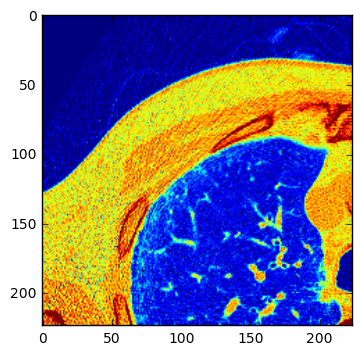

In [75]:
plt.imshow(img_array[13][2])

In [76]:
type(img_array[0][0][0][0])

numpy.float32

In [77]:
len(image_labels)

82

In [78]:
type(image_labels[19])

numpy.float32

In [79]:
ohe_image_labels = to_categorical(np.array(np.float32(image_labels))).astype(np.float32)

In [80]:
type(ohe_image_labels[0][0])

numpy.float32

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
trn_labels, val_labels = train_test_split(ohe_image_labels, test_size=0.2, random_state=42)

In [83]:
trn,val = train_test_split(img_array, test_size=0.2, random_state=42,)

In [84]:
trn.shape

(65, 3, 224, 224)

In [85]:
type(val[0][0][1][0])

numpy.float32

In [86]:
batch_size = 4

In [87]:
type(val[1][0][1][0])

numpy.float32

In [ ]:

model.fit(trn, 
          trn_labels, 
          batch_size=batch_size, 
          nb_epoch=1, 
          validation_data=(val, val_labels))


--Return--
> /Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/theano/tensor/var.py(824)__init__()->None
-> pdb.set_trace()
(Pdb) ll
795  	    def __init__(self, type, owner=None, index=None, name=None):
796  	        super(TensorVariable, self).__init__(type, owner=owner,
797  	                                             index=index, name=name)
798  	        if (config.warn_float64 != 'ignore' and type.dtype == 'float64'):
799  	            msg = ('You are creating a TensorVariable '
800  	                   'with float64 dtype. You requested an action via '
801  	                   'the Theano flag warn_float64={ignore,warn,raise,pdb}.')
802  	            if config.warn_float64 == "warn":
803  	                # Get the user stack. We don't want function inside the
804  	                # tensor and gof directory to be shown to the user.
805  	                x = tb.extract_stack()
806  	                nb_rm = 0
807  	                while x:
808  	                   

In [ ]:
model.save_weights(data_path+'results/ft1.h5')

In [ ]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [ ]:
conv_layers

In [ ]:
conv_model = Sequential(conv_layers)

In [ ]:
%time conv_val_feat = conv_model.predict(val)

In [ ]:
conv_val_feat.shape

In [ ]:
%time conv_feat = conv_model.predict(trn)